# [training] 3rd place solution

I will post a description of the model in discussion. Inference is done in another notebook.
* Inference: https://www.kaggle.com/sugghi/inference-3rd-place-solution/

I referred to various notebooks when coding. In particular, the following notebooks were used directly.
* Submitting Lagged Features via API：
https://www.kaggle.com/tomforbes/gresearch-submitting-lagged-features-via-api
* EmbargoCV：
https://www.kaggle.com/nrcjea001/lgbm-embargocv-weightedpearson-lagtarget/notebook

In addition, although not used in this notebook, local api published by @jagofc helped me a lot in coding.
* local api：https://www.kaggle.com/code/jagofc/local-api/

As you can see from my code, I am a novice in machine learning and python.
If you see anything  to improve on or any mistakes, I'd be very happy to hear about them!

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import gresearch_crypto
import time
import datetime

import pickle
import gc

from tqdm import tqdm

n_fold = 7
seed0 = 8586
use_supple_for_train = True

# If True, the period used to evaluate Public LB will not be used for training.
# Set to False on final submission.
not_use_overlap_to_train = False

TRAIN_CSV = '/kaggle/input/g-research-crypto-forecasting/train.csv'
SUPPLE_TRAIN_CSV = '/kaggle/input/g-research-crypto-forecasting/supplemental_train.csv'
ASSET_DETAILS_CSV = '/kaggle/input/g-research-crypto-forecasting/asset_details.csv'

pd.set_option('display.max_rows', 6)
pd.set_option('display.max_columns', 350)

In [2]:
lags = [60,300,900]

In [3]:
params = {
    'early_stopping_rounds': 50,
    'objective': 'regression',
    'metric': 'rmse',
#     'metric': 'None',
    'boosting_type': 'gbdt',
    'max_depth': 5,
    'verbose': -1,
    'max_bin':600,
    'min_data_in_leaf':50,
    'learning_rate': 0.03,
    'subsample': 0.7,
    'subsample_freq': 1,
    'feature_fraction': 1,
    'lambda_l1': 0.5,
    'lambda_l2': 2,
    'seed':seed0,
    'feature_fraction_seed': seed0,
    'bagging_fraction_seed': seed0,
    'drop_seed': seed0,
    'data_random_seed': seed0,
    'extra_trees': True,
    'extra_seed': seed0,
    'zero_as_missing': True,
    "first_metric_only": True
         }

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [5]:
df_asset_details = pd.read_csv(ASSET_DETAILS_CSV).sort_values("Asset_ID")
# df_asset_details

# Preprocessing

In [6]:
%%time
df_train = pd.read_csv(TRAIN_CSV, usecols=['timestamp','Asset_ID', 'Close', 'Target'])

if use_supple_for_train:    
    df_supple = pd.read_csv(SUPPLE_TRAIN_CSV, usecols=['timestamp','Asset_ID', 'Close', 'Target'])
#     display(df_supple)
    df_train = pd.concat([df_train, df_supple])
    del df_supple
df_train = reduce_mem_usage(df_train)
# df_train

Memory usage of dataframe is 1020.63 MB
Memory usage after optimization is: 484.80 MB
Decreased by 52.5%
CPU times: user 32.4 s, sys: 3.91 s, total: 36.3 s
Wall time: 59.6 s


In [7]:
%%time
train_merged = pd.DataFrame()
train_merged[df_train.columns] = 0
for id in tqdm( range(14) ):
    train_merged = train_merged.merge(df_train.loc[df_train["Asset_ID"] == id, ['timestamp', 'Close','Target']].copy(), on="timestamp", how='outer',suffixes=['', "_"+str(id)])
        
train_merged = train_merged.drop(df_train.columns.drop("timestamp"), axis=1)
train_merged = train_merged.sort_values('timestamp', ascending=True)
display(train_merged.head())

100%|██████████| 14/14 [00:22<00:00,  1.58s/it]


,timestamp,Close_0,Target_0,Close_1,Target_1,Close_2,Target_2,Close_3,Target_3,Close_4,Target_4,Close_5,Target_5,Close_6,Target_6,Close_7,Target_7,Close_8,Target_8,Close_9,Target_9,Close_10,Target_10,Close_11,Target_11,Close_12,Target_12,Close_13,Target_13
0,1514764860,8.5300,-0.014397,13850.175781,-0.014641,2374.590088,-0.004219,NaN,NaN,NaN,NaN,7.6576,-0.013924,738.507507,-0.004810,25.877001,-0.008263,NaN,NaN,225.206665,-0.009789,NaN,NaN,329.459991,NaN,NaN,NaN,NaN,NaN
1,1514764920,8.5145,-0.015869,13828.101562,-0.015038,2372.286621,-0.004078,NaN,NaN,NaN,NaN,7.6567,-0.014534,738.260010,-0.004440,25.896999,-0.029907,NaN,NaN,224.856674,-0.012993,NaN,NaN,329.450012,-0.009689,NaN,NaN,NaN,NaN
2,1514764980,8.4848,-0.015411,13801.314453,-0.010307,2372.063232,-0.002892,NaN,NaN,NaN,NaN,7.6512,-0.012543,737.502502,-0.004204,26.469500,-0.030838,NaN,NaN,226.000000,-0.003571,NaN,NaN,329.190002,0.006565,NaN,NaN,NaN,NaN
3,1514765040,8.5009,-0.012527,13768.040039,-0.009003,2370.566650,-0.003719,NaN,NaN,NaN,NaN,7.6358,-0.011169,737.102478,-0.002205,26.449499,-0.028900,NaN,NaN,224.274994,-0.002556,NaN,NaN,328.160004,-0.007298,NaN,NaN,NaN,NaN
4,1514765100,8.4560,-0.005939,13724.914062,-0.008080,2370.173340,-0.002171,NaN,NaN,NaN,NaN,7.6100,-0.006153,735.705017,-0.001744,26.437000,-0.030914,NaN,NaN,223.820007,0.000531,NaN,NaN,327.429993,-0.010620,NaN,NaN,NaN,NaN


CPU times: user 17.7 s, sys: 4.88 s, total: 22.6 s
Wall time: 22.6 s


In [8]:
# forward fill
# Set an upper limit on the number of fills, since there may be long term gaps.
for id in range(14):
#     print(id, train_merged[f'Close_{id}'].isnull().sum())   # Number of missing before forward fill
    train_merged[f'Close_{id}'] = train_merged[f'Close_{id}'].fillna(method='ffill', limit=100)
#     print(id, train_merged[f'Close_{id}'].isnull().sum())   # Number of missing after forward fill

# Feature Engineering

In [9]:
def get_features(df, train=True):   
    if train == True:
        totimestamp = lambda s: np.int32(time.mktime(datetime.datetime.strptime(s, "%d/%m/%Y").timetuple()))
        valid_window = [totimestamp("12/03/2021")]
#         valid_window = [totimestamp("15/08/2021")]  #検証用
        df['train_flg'] = np.where(df['timestamp']>=valid_window[0], 0,1)

        supple_start_window = [totimestamp("22/09/2021")]
        if use_supple_for_train:
            df['train_flg'] = np.where(df['timestamp']>=supple_start_window[0], 1 ,df['train_flg']  )

   
    for id in range(14):    
        for lag in lags:
            df[f'log_close/mean_{lag}_id{id}'] = np.log( np.array(df[f'Close_{id}']) /  np.roll(np.append(np.convolve( np.array(df[f'Close_{id}']), np.ones(lag)/lag, mode="valid"), np.ones(lag-1)), lag-1)  )
            df[f'log_return_{lag}_id{id}']     = np.log( np.array(df[f'Close_{id}']) /  np.roll(np.array(df[f'Close_{id}']), lag)  )
    for lag in lags:
        df[f'mean_close/mean_{lag}'] =  np.mean(df.iloc[:,df.columns.str.startswith(f'log_close/mean_{lag}_id')], axis=1)
        df[f'mean_log_returns_{lag}'] = np.mean(df.iloc[:,df.columns.str.startswith(f'log_return_{lag}_id')] ,    axis=1)
        for id in range(14):
            df[f'log_close/mean_{lag}-mean_close/mean_{lag}_id{id}'] = np.array( df[f'log_close/mean_{lag}_id{id}']) - np.array( df[f'mean_close/mean_{lag}']  )
            df[f'log_return_{lag}-mean_log_returns_{lag}_id{id}']    = np.array( df[f'log_return_{lag}_id{id}'])     - np.array( df[f'mean_log_returns_{lag}'] )

    if train == True:
        for id in range(14):
            df = df.drop([f'Close_{id}'], axis=1)
        oldest_use_window = [totimestamp("12/01/2019")]
        df = df[  df['timestamp'] >= oldest_use_window[0]   ]

    return df

In [10]:
%%time
feat = get_features(train_merged)
feat

CPU times: user 20.9 s, sys: 11.5 s, total: 32.4 s
Wall time: 32.4 s


,timestamp,Target_0,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7,Target_8,Target_9,Target_10,Target_11,Target_12,Target_13,train_flg,log_close/mean_60_id0,log_return_60_id0,log_close/mean_300_id0,log_return_300_id0,log_close/mean_900_id0,log_return_900_id0,log_close/mean_60_id1,log_return_60_id1,log_close/mean_300_id1,log_return_300_id1,log_close/mean_900_id1,log_return_900_id1,log_close/mean_60_id2,log_return_60_id2,log_close/mean_300_id2,log_return_300_id2,log_close/mean_900_id2,log_return_900_id2,log_close/mean_60_id3,log_return_60_id3,log_close/mean_300_id3,log_return_300_id3,log_close/mean_900_id3,log_return_900_id3,log_close/mean_60_id4,log_return_60_id4,log_close/mean_300_id4,log_return_300_id4,log_close/mean_900_id4,log_return_900_id4,log_close/mean_60_id5,log_return_60_id5,log_close/mean_300_id5,log_return_300_id5,log_close/mean_900_id5,log_return_900_id5,log_close/mean_60_id6,log_return_60_id6,log_close/mean_300_id6,log_return_300_id6,log_close/mean_900_id6,log_return_900_id6,log_close/mean_60_id7,log_return_60_id7,log_close/mean_300_id7,log_return_300_id7,log_close/mean_900_id7,log_return_900_id7,log_close/mean_60_id8,log_return_60_id8,log_close/mean_300_id8,log_return_300_id8,log_close/mean_900_id8,log_return_900_id8,log_close/mean_60_id9,log_return_60_id9,log_close/mean_300_id9,log_return_300_id9,log_close/mean_900_id9,log_return_900_id9,log_close/mean_60_id10,log_return_60_id10,log_close/mean_300_id10,log_return_300_id10,log_close/mean_900_id10,log_return_900_id10,log_close/mean_60_id11,log_return_60_id11,log_close/mean_300_id11,log_return_300_id11,log_close/mean_900_id11,log_return_900_id11,log_close/mean_60_id12,log_return_60_id12,log_close/mean_300_id12,log_return_300_id12,log_close/mean_900_id12,log_return_900_id12,log_close/mean_60_id13,log_return_60_id13,log_close/mean_300_id13,log_return_300_id13,log_close/mean_900_id13,log_return_900_id13,mean_close/mean_60,mean_log_returns_60,log_close/mean_60-mean_close/mean_60_id0,log_return_60-mean_log_returns_60_id0,log_close/mean_60-mean_close/mean_60_id1,log_return_60-mean_log_returns_60_id1,log_close/mean_60-mean_close/mean_60_id2,log_return_60-mean_log_returns_60_id2,log_close/mean_60-mean_close/mean_60_id3,log_return_60-mean_log_returns_60_id3,log_close/mean_60-mean_close/mean_60_id4,log_return_60-mean_log_returns_60_id4,log_close/mean_60-mean_close/mean_60_id5,log_return_60-mean_log_returns_60_id5,log_close/mean_60-mean_close/mean_60_id6,log_return_60-mean_log_returns_60_id6,log_close/mean_60-mean_close/mean_60_id7,log_return_60-mean_log_returns_60_id7,log_close/mean_60-mean_close/mean_60_id8,log_return_60-mean_log_returns_60_id8,log_close/mean_60-mean_close/mean_60_id9,log_return_60-mean_log_returns_60_id9,log_close/mean_60-mean_close/mean_60_id10,log_return_60-mean_log_returns_60_id10,log_close/mean_60-mean_close/mean_60_id11,log_return_60-mean_log_returns_60_id11,log_close/mean_60-mean_close/mean_60_id12,log_return_60-mean_log_returns_60_id12,log_close/mean_60-mean_close/mean_60_id13,log_return_60-mean_log_returns_60_id13,mean_close/mean_300,mean_log_returns_300,log_close/mean_300-mean_close/mean_300_id0,log_return_300-mean_log_returns_300_id0,log_close/mean_300-mean_close/mean_300_id1,log_return_300-mean_log_returns_300_id1,log_close/mean_300-mean_close/mean_300_id2,log_return_300-mean_log_returns_300_id2,log_close/mean_300-mean_close/mean_300_id3,log_return_300-mean_log_returns_300_id3,log_close/mean_300-mean_close/mean_300_id4,log_return_300-mean_log_returns_300_id4,log_close/mean_300-mean_close/mean_300_id5,log_return_300-mean_log_returns_300_id5,log_close/mean_300-mean_close/mean_300_id6,log_return_300-mean_log_returns_300_id6,log_close/mean_300-mean_close/mean_300_id7,log_return_300-mean_log_returns_300_id7,log_close/mean_300-mean_close/mean_300_id8,log_return_300-mean_log_returns_300_id8,log_close/mean_300-mean_close/mean_300_id9,log_return_300-mean_log_returns_300_id9,log_close/mean_300-mean_close/mean_300_id10,log_return_300-mean_l

In [11]:
# define features for LGBM
not_use_features_train = ['timestamp', 'train_flg']
for id in range(14):
    not_use_features_train.append(f'Target_{id}')

features = feat.columns 
features = features.drop(not_use_features_train)
features = list(features)
# display(features)  
len(features)

174

In [12]:
del train_merged
del df_train
gc.collect()

83

# Training

In [13]:
# define the evaluation metric
def correlation(a, train_data):
    
    b = train_data.get_label()
    
    a = np.ravel(a)
    b = np.ravel(b)

    len_data = len(a)
    mean_a = np.sum(a) / len_data
    mean_b = np.sum(b) / len_data
    var_a = np.sum(np.square(a - mean_a)) / len_data
    var_b = np.sum(np.square(b - mean_b)) / len_data

    cov = np.sum((a * b))/len_data - mean_a*mean_b
    corr = cov / np.sqrt(var_a * var_b)

    return 'corr', corr, True

# For CV score calculation
def corr_score(pred, valid):
    len_data = len(pred)
    mean_pred = np.sum(pred) / len_data
    mean_valid = np.sum(valid) / len_data
    var_pred = np.sum(np.square(pred - mean_pred)) / len_data
    var_valid = np.sum(np.square(valid - mean_valid)) / len_data

    cov = np.sum((pred * valid))/len_data - mean_pred*mean_valid
    corr = cov / np.sqrt(var_pred * var_valid)

    return corr

# For CV score calculation
def wcorr_score(pred, valid, weight):
    len_data = len(pred)
    sum_w = np.sum(weight)
    mean_pred = np.sum(pred * weight) / sum_w
    mean_valid = np.sum(valid * weight) / sum_w
    var_pred = np.sum(weight * np.square(pred - mean_pred)) / sum_w
    var_valid = np.sum(weight * np.square(valid - mean_valid)) / sum_w

    cov = np.sum((pred * valid * weight)) / sum_w - mean_pred*mean_valid
    corr = cov / np.sqrt(var_pred * var_valid)

    return corr

In [14]:
# from: https://blog.amedama.jp/entry/lightgbm-cv-feature-importance
# (used in nyanp's Optiver solution)
def plot_importance(importances, features_names = features, PLOT_TOP_N = 20, figsize=(10, 10)):
    importance_df = pd.DataFrame(data=importances, columns=features)
    sorted_indices = importance_df.median(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()

In [15]:
# from: https://www.kaggle.com/code/nrcjea001/lgbm-embargocv-weightedpearson-lagtarget/
def get_time_series_cross_val_splits(data, cv = n_fold, embargo = 3750):
    all_train_timestamps = data['timestamp'].unique()
    len_split = len(all_train_timestamps) // cv
    test_splits = [all_train_timestamps[i * len_split:(i + 1) * len_split] for i in range(cv)]
    # fix the last test split to have all the last timestamps, in case the number of timestamps wasn't divisible by cv
    rem = len(all_train_timestamps) - len_split*cv
    if rem>0:
        test_splits[-1] = np.append(test_splits[-1], all_train_timestamps[-rem:])

    train_splits = []
    for test_split in test_splits:
        test_split_max = int(np.max(test_split))
        test_split_min = int(np.min(test_split))
        # get all of the timestamps that aren't in the test split
        train_split_not_embargoed = [e for e in all_train_timestamps if not (test_split_min <= int(e) <= test_split_max)]
        # embargo the train split so we have no leakage. Note timestamps are expressed in seconds, so multiply by 60
        embargo_sec = 60*embargo
        train_split = [e for e in train_split_not_embargoed if
                       abs(int(e) - test_split_max) > embargo_sec and abs(int(e) - test_split_min) > embargo_sec]
        train_splits.append(train_split)

    # convenient way to iterate over train and test splits
    train_test_zip = zip(train_splits, test_splits)
    return train_test_zip

In [16]:
def get_Xy_and_model_for_asset(df_proc, asset_id):
    df_proc = df_proc.loc[  (df_proc[f'Target_{asset_id}'] == df_proc[f'Target_{asset_id}'])  ]
    if not_use_overlap_to_train:
        df_proc = df_proc.loc[  (df_proc['train_flg'] == 1)  ]
    
# EmbargoCV
    train_test_zip = get_time_series_cross_val_splits(df_proc, cv = n_fold, embargo = 3750)
    print("entering time series cross validation loop")
    importances = []
    oof_pred = []
    oof_valid = []
    
    for split, train_test_split in enumerate(train_test_zip):
        gc.collect()
        
        print(f"doing split {split+1} out of {n_fold}")
        train_split, test_split = train_test_split
        train_split_index = df_proc['timestamp'].isin(train_split)
        test_split_index = df_proc['timestamp'].isin(test_split)
    
        train_dataset = lgb.Dataset(df_proc.loc[train_split_index, features],
                                    df_proc.loc[train_split_index, f'Target_{asset_id}'].values, 
                                    feature_name = features, 
                                   )
        val_dataset = lgb.Dataset(df_proc.loc[test_split_index, features], 
                                  df_proc.loc[test_split_index, f'Target_{asset_id}'].values, 
                                  feature_name = features, 
                                 )

        print(f"number of train data: {len(df_proc.loc[train_split_index])}")
        print(f"number of val data:   {len(df_proc.loc[test_split_index])}")

        model = lgb.train(params = params,
                          train_set = train_dataset, 
                          valid_sets=[train_dataset, val_dataset],
                          valid_names=['tr', 'vl'],
                          num_boost_round = 5000,
                          verbose_eval = 100,     
                          feval = correlation,
                         )
        importances.append(model.feature_importance(importance_type='gain'))
        
        file = f'trained_model_id{asset_id}_fold{split}.pkl'
        pickle.dump(model, open(file, 'wb'))
        print(f"Trained model was saved to 'trained_model_id{asset_id}_fold{split}.pkl'")
        print("")
            
        oof_pred += list(  model.predict(df_proc.loc[test_split_index, features])        )
        oof_valid += list(   df_proc.loc[test_split_index, f'Target_{asset_id}'].values    )
    
    
    plot_importance(np.array(importances),features, PLOT_TOP_N = 20, figsize=(10, 5))

    return oof_pred, oof_valid

Training model for Binance Coin     (ID=0 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 1357044
number of val data:   226799


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00378262	tr's corr: 0.220344	vl's rmse: 0.00491424	vl's corr: 0.0619737
[200]	tr's rmse: 0.00375516	tr's corr: 0.271031	vl's rmse: 0.00491247	vl's corr: 0.0636731
Early stopping, best iteration is:
[244]	tr's rmse: 0.00374468	tr's corr: 0.285268	vl's rmse: 0.00491141	vl's corr: 0.0666244
Evaluated only: rmse
Trained model was saved to 'trained_model_id0_fold0.pkl'

doing split 2 out of 7
number of train data: 1353302
number of val data:   226799
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00395832	tr's corr: 0.217551	vl's rmse: 0.00398273	vl's corr: 0.0755886
[200]	tr's rmse: 0.00393082	tr's corr: 0.264245	vl's rmse: 0.00398097	vl's corr: 0.0773163
Early stopping, best iteration is:
[246]	tr's rmse: 0.00391894	tr's corr: 0.2825	vl's rmse: 0.00398055	vl's corr: 0.0778464
Evaluated only: rmse
Trained model was saved to 'trained_model_id0_fold1.pkl'

doing split 3 out of 7
n

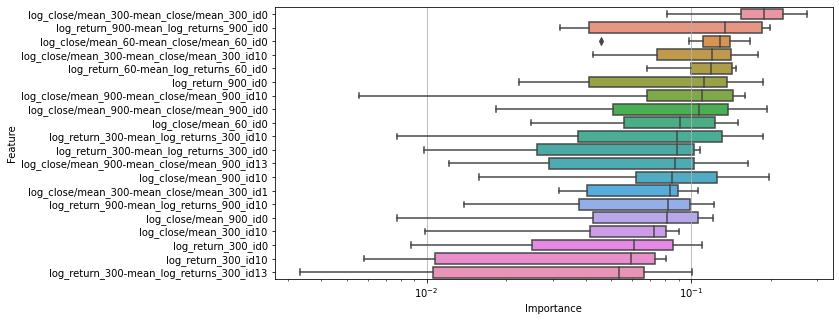

OOF corr score of Binance Coin (ID=0) is 0.05844. (Weight: 4.30407)


Training model for Bitcoin          (ID=1 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 1362991
number of val data:   227790


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00197328	tr's corr: 0.183399	vl's rmse: 0.00191116	vl's corr: 0.057791
[200]	tr's rmse: 0.00196172	tr's corr: 0.234105	vl's rmse: 0.00191071	vl's corr: 0.0582637
Early stopping, best iteration is:
[224]	tr's rmse: 0.00195915	tr's corr: 0.244071	vl's rmse: 0.00191045	vl's corr: 0.0608193
Evaluated only: rmse
Trained model was saved to 'trained_model_id1_fold0.pkl'

doing split 2 out of 7
number of train data: 1359241
number of val data:   227790
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00193656	tr's corr: 0.18083	vl's rmse: 0.00213495	vl's corr: 0.0306209
Early stopping, best iteration is:
[66]	tr's rmse: 0.00194056	tr's corr: 0.158751	vl's rmse: 0.00213468	vl's corr: 0.0367302
Evaluated only: rmse
Trained model was saved to 'trained_model_id1_fold1.pkl'

doing split 3 out of 7
number of train data: 1359241
number of val data:   227790
Training until validation scores d

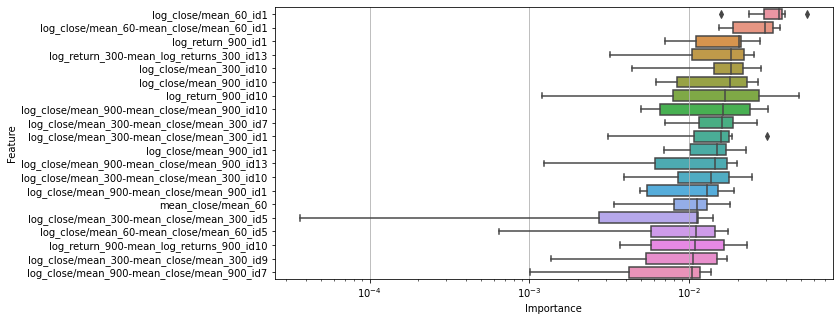

OOF corr score of Bitcoin (ID=1) is 0.04302. (Weight: 6.77992)


Training model for Bitcoin Cash     (ID=2 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 1358670
number of val data:   227070


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00331692	tr's corr: 0.211553	vl's rmse: 0.00469524	vl's corr: 0.0653636
Early stopping, best iteration is:
[119]	tr's rmse: 0.00331024	tr's corr: 0.226843	vl's rmse: 0.00469517	vl's corr: 0.0652037
Evaluated only: rmse
Trained model was saved to 'trained_model_id2_fold0.pkl'

doing split 2 out of 7
number of train data: 1354920
number of val data:   227070
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00358428	tr's corr: 0.197231	vl's rmse: 0.00336052	vl's corr: 0.0873324
Early stopping, best iteration is:
[85]	tr's rmse: 0.00358945	tr's corr: 0.184767	vl's rmse: 0.00336035	vl's corr: 0.0894923
Evaluated only: rmse
Trained model was saved to 'trained_model_id2_fold1.pkl'

doing split 3 out of 7
number of train data: 1354926
number of val data:   227070
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	tr's rmse: 0.00362096	

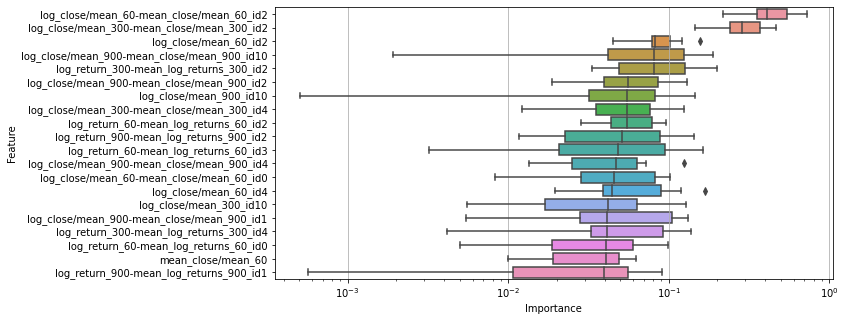

OOF corr score of Bitcoin Cash (ID=2) is 0.07852. (Weight: 2.39790)


Training model for Cardano          (ID=3 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 1337949
number of val data:   223615


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00421053	tr's corr: 0.197917	vl's rmse: 0.00412136	vl's corr: 0.0831348
[200]	tr's rmse: 0.00418062	tr's corr: 0.244545	vl's rmse: 0.00411837	vl's corr: 0.0894927
[300]	tr's rmse: 0.00415553	tr's corr: 0.278213	vl's rmse: 0.00411735	vl's corr: 0.0919038
Early stopping, best iteration is:
[314]	tr's rmse: 0.00415259	tr's corr: 0.281867	vl's rmse: 0.00411709	vl's corr: 0.0925439
Evaluated only: rmse
Trained model was saved to 'trained_model_id3_fold0.pkl'

doing split 2 out of 7
number of train data: 1335055
number of val data:   223615
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00406901	tr's corr: 0.188048	vl's rmse: 0.00493297	vl's corr: 0.0768853
[200]	tr's rmse: 0.00404107	tr's corr: 0.234702	vl's rmse: 0.00493017	vl's corr: 0.0814437
[300]	tr's rmse: 0.00401903	tr's corr: 0.267546	vl's rmse: 0.00492837	vl's corr: 0.0850532
[400]	tr's rmse: 0.00399834	tr's corr: 0.2952

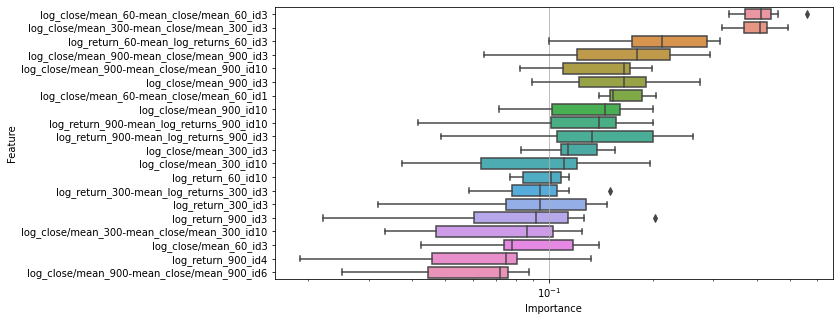

OOF corr score of Cardano (ID=3) is 0.09111. (Weight: 4.40672)


Training model for Dogecoin         (ID=4 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 1019207
number of val data:   170260


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00773962	tr's corr: 0.397441	vl's rmse: 0.00550745	vl's corr: 0.0769092
Early stopping, best iteration is:
[53]	tr's rmse: 0.00784807	tr's corr: 0.344759	vl's rmse: 0.00550615	vl's corr: 0.0915729
Evaluated only: rmse
Trained model was saved to 'trained_model_id4_fold0.pkl'

doing split 2 out of 7
number of train data: 1018401
number of val data:   170260
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00771568	tr's corr: 0.389721	vl's rmse: 0.0059557	vl's corr: 0.115735
[200]	tr's rmse: 0.00753366	tr's corr: 0.452567	vl's rmse: 0.00594757	vl's corr: 0.122087
[300]	tr's rmse: 0.00738654	tr's corr: 0.487389	vl's rmse: 0.00594193	vl's corr: 0.128218
Early stopping, best iteration is:
[346]	tr's rmse: 0.00733025	tr's corr: 0.499111	vl's rmse: 0.0059388	vl's corr: 0.131576
Evaluated only: rmse
Trained model was saved to 'trained_model_id4_fold1.pkl'

doing split 3 out of 7
number

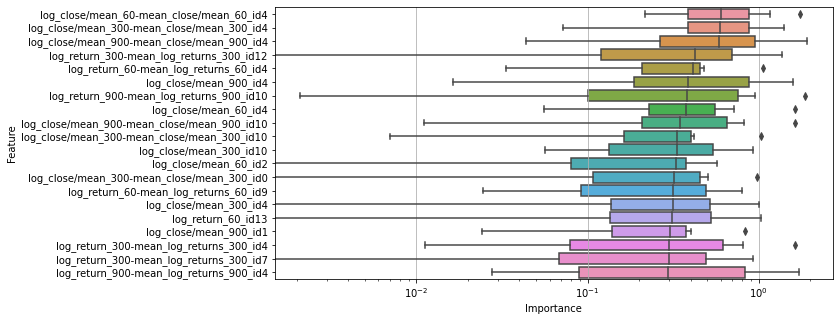

OOF corr score of Dogecoin (ID=4) is 0.05538. (Weight: 3.55535)


Training model for EOS.IO           (ID=5 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 1362792
number of val data:   227757


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00376836	tr's corr: 0.190706	vl's rmse: 0.0048589	vl's corr: 0.0780155
[200]	tr's rmse: 0.00373564	tr's corr: 0.260307	vl's rmse: 0.00485886	vl's corr: 0.0732318
Early stopping, best iteration is:
[159]	tr's rmse: 0.00374842	tr's corr: 0.237025	vl's rmse: 0.00485873	vl's corr: 0.0749213
Evaluated only: rmse
Trained model was saved to 'trained_model_id5_fold0.pkl'

doing split 2 out of 7
number of train data: 1359042
number of val data:   227757
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00406158	tr's corr: 0.168933	vl's rmse: 0.00317077	vl's corr: 0.0786223
Early stopping, best iteration is:
[87]	tr's rmse: 0.00406552	tr's corr: 0.158711	vl's rmse: 0.00317046	vl's corr: 0.0798414
Evaluated only: rmse
Trained model was saved to 'trained_model_id5_fold1.pkl'

doing split 3 out of 7
number of train data: 1359042
number of val data:   227757
Training until validation scores 

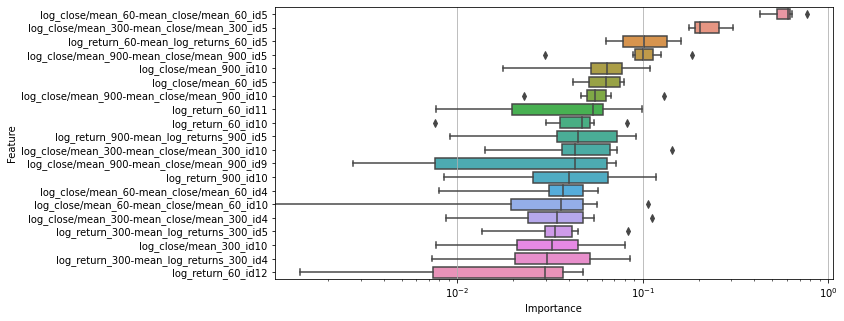

OOF corr score of EOS.IO (ID=5) is 0.07083. (Weight: 1.38629)


Training model for Ethereum         (ID=6 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 1362890
number of val data:   227773


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00224341	tr's corr: 0.160849	vl's rmse: 0.00260016	vl's corr: 0.085359
[200]	tr's rmse: 0.00223153	tr's corr: 0.204515	vl's rmse: 0.0025993	vl's corr: 0.0866606
Early stopping, best iteration is:
[167]	tr's rmse: 0.00223506	tr's corr: 0.192039	vl's rmse: 0.00259912	vl's corr: 0.0875349
Evaluated only: rmse
Trained model was saved to 'trained_model_id6_fold0.pkl'

doing split 2 out of 7
number of train data: 1359140
number of val data:   227773
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00233729	tr's corr: 0.150715	vl's rmse: 0.00206059	vl's corr: 0.108334
[200]	tr's rmse: 0.00232516	tr's corr: 0.198004	vl's rmse: 0.00205896	vl's corr: 0.11235
[300]	tr's rmse: 0.00231543	tr's corr: 0.228234	vl's rmse: 0.00205833	vl's corr: 0.113673
[400]	tr's rmse: 0.00230724	tr's corr: 0.251179	vl's rmse: 0.00205815	vl's corr: 0.113683
[500]	tr's rmse: 0.00229966	tr's corr: 0.270598	vl's

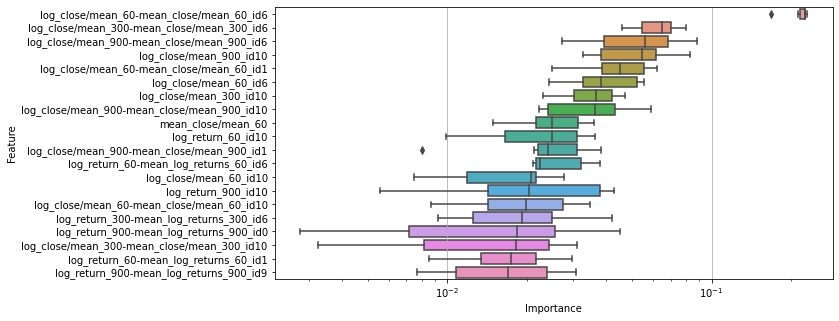

OOF corr score of Ethereum (ID=6) is 0.08913. (Weight: 5.89440)


Training model for Ethereum Classic (ID=7 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 1355915
number of val data:   226610


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00928035	tr's corr: 0.134229	vl's rmse: 0.00758892	vl's corr: 0.0580884
Early stopping, best iteration is:
[69]	tr's rmse: 0.00929431	tr's corr: 0.120685	vl's rmse: 0.0075879	vl's corr: 0.0598559
Evaluated only: rmse
Trained model was saved to 'trained_model_id7_fold0.pkl'

doing split 2 out of 7
number of train data: 1352198
number of val data:   226610
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.0091348	tr's corr: 0.132166	vl's rmse: 0.00866646	vl's corr: 0.104392
[200]	tr's rmse: 0.00910191	tr's corr: 0.165028	vl's rmse: 0.00866237	vl's corr: 0.103867
[300]	tr's rmse: 0.00907381	tr's corr: 0.189709	vl's rmse: 0.00866112	vl's corr: 0.10299
[400]	tr's rmse: 0.00905083	tr's corr: 0.207306	vl's rmse: 0.00866004	vl's corr: 0.103261
Early stopping, best iteration is:
[439]	tr's rmse: 0.00904282	tr's corr: 0.213286	vl's rmse: 0.00865933	vl's corr: 0.103836
Evaluated only: rms

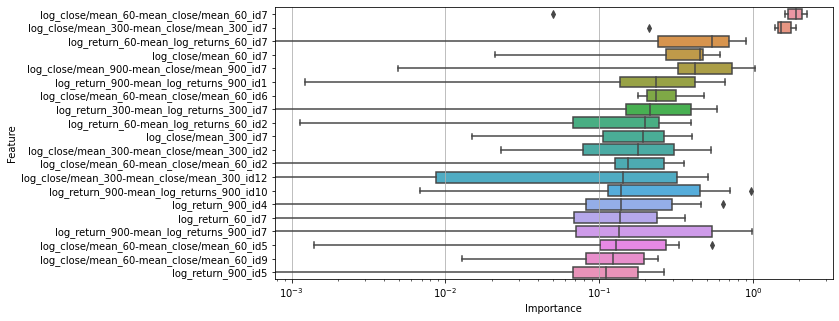

OOF corr score of Ethereum Classic (ID=7) is 0.07589. (Weight: 2.07944)


Training model for IOTA             (ID=8 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 1057838
number of val data:   176931


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00889866	tr's corr: 0.184749	vl's rmse: 0.00750731	vl's corr: 0.0640048
[200]	tr's rmse: 0.00884969	tr's corr: 0.215258	vl's rmse: 0.00750447	vl's corr: 0.0689169
Early stopping, best iteration is:
[209]	tr's rmse: 0.00884644	tr's corr: 0.217996	vl's rmse: 0.00750436	vl's corr: 0.0689182
Evaluated only: rmse
Trained model was saved to 'trained_model_id8_fold0.pkl'

doing split 2 out of 7
number of train data: 1056983
number of val data:   176931
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00912681	tr's corr: 0.181192	vl's rmse: 0.00546173	vl's corr: 0.0980027
[200]	tr's rmse: 0.00908158	tr's corr: 0.211721	vl's rmse: 0.00545815	vl's corr: 0.0970894
Early stopping, best iteration is:
[244]	tr's rmse: 0.00906579	tr's corr: 0.221806	vl's rmse: 0.00545627	vl's corr: 0.0995894
Evaluated only: rmse
Trained model was saved to 'trained_model_id8_fold1.pkl'

doing split 3 out of 7

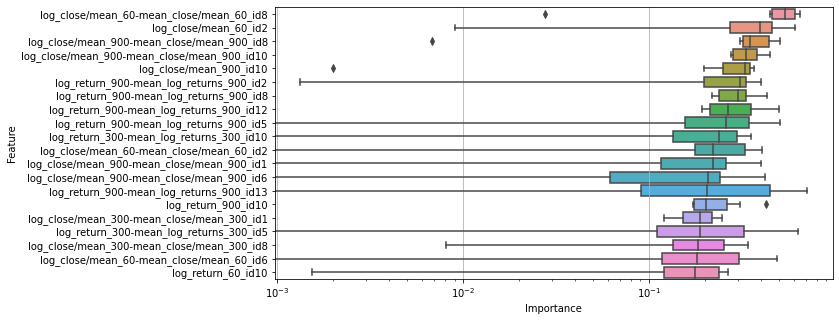

OOF corr score of IOTA (ID=8) is 0.04417. (Weight: 1.09861)


Training model for Litecoin         (ID=9 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 1362589
number of val data:   227723


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00315779	tr's corr: 0.165154	vl's rmse: 0.00433658	vl's corr: 0.0883326
[200]	tr's rmse: 0.00313943	tr's corr: 0.212229	vl's rmse: 0.00433528	vl's corr: 0.0893569
Early stopping, best iteration is:
[202]	tr's rmse: 0.00313918	tr's corr: 0.212787	vl's rmse: 0.00433522	vl's corr: 0.0895162
Evaluated only: rmse
Trained model was saved to 'trained_model_id9_fold0.pkl'

doing split 2 out of 7
number of train data: 1358839
number of val data:   227723
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00339524	tr's corr: 0.155066	vl's rmse: 0.00302913	vl's corr: 0.10724
[200]	tr's rmse: 0.00337782	tr's corr: 0.197355	vl's rmse: 0.00302703	vl's corr: 0.111461
Early stopping, best iteration is:
[207]	tr's rmse: 0.00337686	tr's corr: 0.199522	vl's rmse: 0.00302698	vl's corr: 0.111542
Evaluated only: rmse
Trained model was saved to 'trained_model_id9_fold1.pkl'

doing split 3 out of 7
num

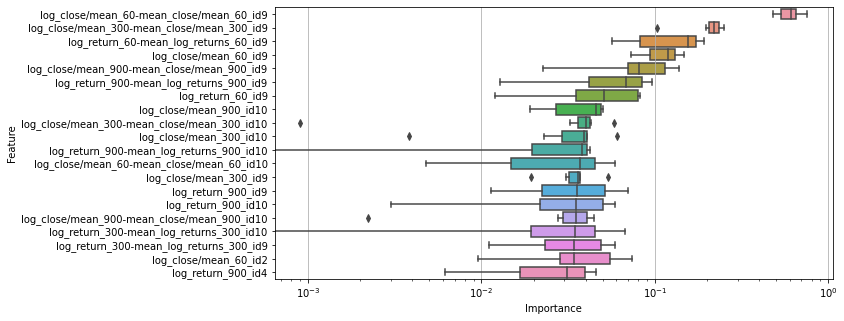

OOF corr score of Litecoin (ID=9) is 0.09453. (Weight: 2.39790)


Training model for Maker            (ID=10)
entering time series cross validation loop
doing split 1 out of 7
number of train data: 688034
number of val data:   115297


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00579983	tr's corr: 0.251345	vl's rmse: 0.00588671	vl's corr: 0.0490252
Early stopping, best iteration is:
[72]	tr's rmse: 0.00582162	tr's corr: 0.230102	vl's rmse: 0.00588627	vl's corr: 0.0505935
Evaluated only: rmse
Trained model was saved to 'trained_model_id10_fold0.pkl'

doing split 2 out of 7
number of train data: 684284
number of val data:   115297
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00604435	tr's corr: 0.247776	vl's rmse: 0.00423031	vl's corr: 0.0554724
Early stopping, best iteration is:
[91]	tr's rmse: 0.00605157	tr's corr: 0.241307	vl's rmse: 0.00423012	vl's corr: 0.0555793
Evaluated only: rmse
Trained model was saved to 'trained_model_id10_fold1.pkl'

doing split 3 out of 7
number of train data: 684284
number of val data:   115297
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00552784	tr's corr: 0.224303	vl's rmse: 0.00

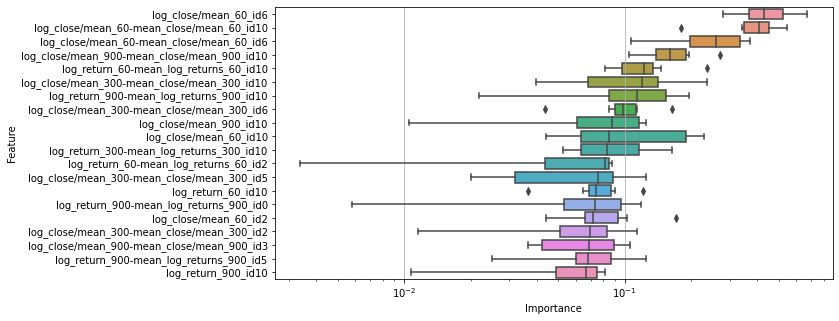

OOF corr score of Maker (ID=10) is 0.06967. (Weight: 1.09861)


Training model for Monero           (ID=11)
entering time series cross validation loop
doing split 1 out of 7
number of train data: 1197984
number of val data:   200280


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00511843	tr's corr: 0.258101	vl's rmse: 0.00706505	vl's corr: 0.059998
[200]	tr's rmse: 0.00506799	tr's corr: 0.301301	vl's rmse: 0.00706194	vl's corr: 0.0625377
Early stopping, best iteration is:
[231]	tr's rmse: 0.00505494	tr's corr: 0.308888	vl's rmse: 0.00706123	vl's corr: 0.0636293
Evaluated only: rmse
Trained model was saved to 'trained_model_id11_fold0.pkl'

doing split 2 out of 7
number of train data: 1194744
number of val data:   200280
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00544515	tr's corr: 0.240273	vl's rmse: 0.00536189	vl's corr: 0.0445405
Early stopping, best iteration is:
[97]	tr's rmse: 0.0054474	tr's corr: 0.237895	vl's rmse: 0.0053616	vl's corr: 0.0452845
Evaluated only: rmse
Trained model was saved to 'trained_model_id11_fold1.pkl'

doing split 3 out of 7
number of train data: 1195378
number of val data:   200280
Training until validation scores 

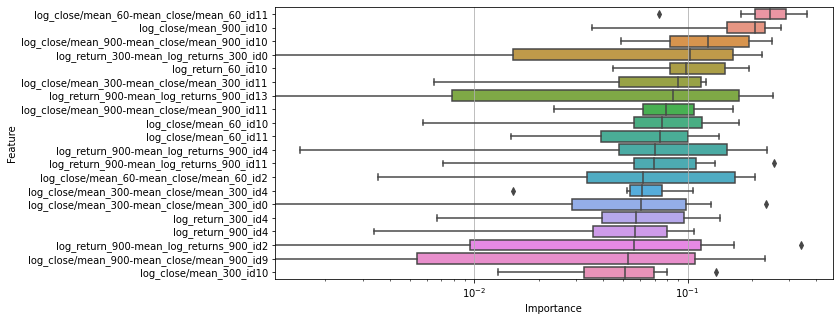

OOF corr score of Monero (ID=11) is 0.04124. (Weight: 1.60944)


Training model for Stellar          (ID=12)
entering time series cross validation loop
doing split 1 out of 7
number of train data: 1357750
number of val data:   226916


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00462509	tr's corr: 0.220858	vl's rmse: 0.00427114	vl's corr: 0.0986555
[200]	tr's rmse: 0.00457122	tr's corr: 0.295338	vl's rmse: 0.00426839	vl's corr: 0.101923
Early stopping, best iteration is:
[216]	tr's rmse: 0.00456392	tr's corr: 0.303611	vl's rmse: 0.0042681	vl's corr: 0.102492
Evaluated only: rmse
Trained model was saved to 'trained_model_id12_fold0.pkl'

doing split 2 out of 7
number of train data: 1354006
number of val data:   226916
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00459381	tr's corr: 0.220207	vl's rmse: 0.0044703	vl's corr: 0.102981
Early stopping, best iteration is:
[142]	tr's rmse: 0.00457261	tr's corr: 0.252861	vl's rmse: 0.00446831	vl's corr: 0.104968
Evaluated only: rmse
Trained model was saved to 'trained_model_id12_fold1.pkl'

doing split 3 out of 7
number of train data: 1354003
number of val data:   226916
Training until validation scores do

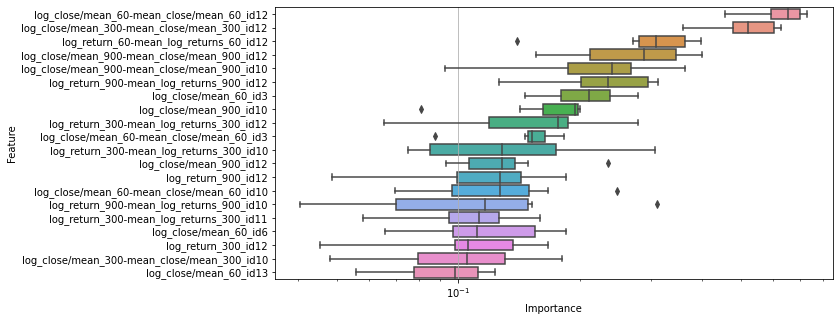

OOF corr score of Stellar (ID=12) is 0.08794. (Weight: 2.07944)


Training model for TRON             (ID=13)
entering time series cross validation loop
doing split 1 out of 7
number of train data: 1362163
number of val data:   227652


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00384988	tr's corr: 0.238128	vl's rmse: 0.00503382	vl's corr: 0.0593971
Early stopping, best iteration is:
[57]	tr's rmse: 0.00387483	tr's corr: 0.169736	vl's rmse: 0.00503132	vl's corr: 0.0714764
Evaluated only: rmse
Trained model was saved to 'trained_model_id13_fold0.pkl'

doing split 2 out of 7
number of train data: 1358413
number of val data:   227652
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00411222	tr's corr: 0.220633	vl's rmse: 0.00358718	vl's corr: 0.08887
Early stopping, best iteration is:
[111]	tr's rmse: 0.0041061	tr's corr: 0.233266	vl's rmse: 0.00358685	vl's corr: 0.0894036
Evaluated only: rmse
Trained model was saved to 'trained_model_id13_fold1.pkl'

doing split 3 out of 7
number of train data: 1358416
number of val data:   227652
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00415478	tr's corr: 0.218	vl's rmse: 0.00329

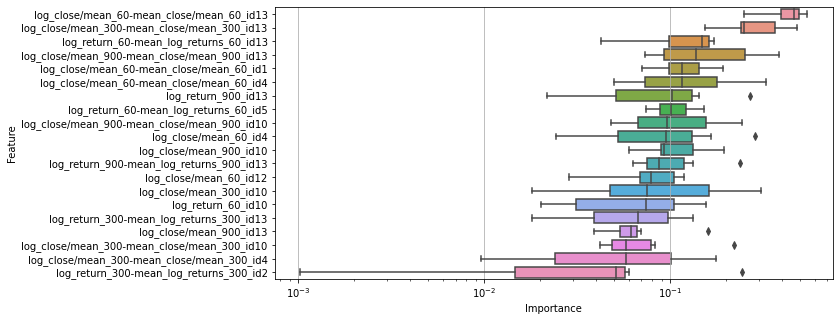

OOF corr score of TRON (ID=13) is 0.07195. (Weight: 1.79176)




In [17]:
oof = [ [] for id in range(14)   ]

all_oof_pred = []
all_oof_valid = []
all_oof_weight = []

for asset_id, asset_name in zip(df_asset_details['Asset_ID'], df_asset_details['Asset_Name']):
    print(f"Training model for {asset_name:<16} (ID={asset_id:<2})")
    
    oof_pred, oof_valid = get_Xy_and_model_for_asset(feat, asset_id)
    
    weight_temp = float( df_asset_details.loc[  df_asset_details['Asset_ID'] == asset_id  , 'Weight'   ]  )
    
    all_oof_pred += oof_pred
    all_oof_valid += oof_valid
    all_oof_weight += [weight_temp] * len(oof_pred)
    
    oof[asset_id] = corr_score(     np.array(oof_pred)   ,    np.array(oof_valid)    )
    
    print(f'OOF corr score of {asset_name} (ID={asset_id}) is {oof[asset_id]:.5f}. (Weight: {float(weight_temp):.5f})')
    print('')
    print('')

In [18]:
# ls -lh

In [19]:
woof = 0
for id in range(14):
    woof += oof[id] * float(  df_asset_details.loc[  df_asset_details['Asset_ID'] == id  , 'Weight'   ] )
woof = woof / df_asset_details['Weight'].sum()

print(f'OOF corr scores are;')
for oof_score in oof:
    print(f'      {oof_score:.5f}')
print(f'  simple average corr score: {np.mean(oof):.5f}.')
print(f'weighted average corr score: {woof:.5f}.')
print(f'')

all_oof_wcorr = wcorr_score(     np.array(all_oof_pred),    np.array(all_oof_valid),  np.array(all_oof_weight)   )
print(f'        weighted corr score: {all_oof_wcorr:.5f}.')

OOF corr scores are;
      0.05844
      0.04302
      0.07852
      0.09111
      0.05538
      0.07083
      0.08913
      0.07589
      0.04417
      0.09453
      0.06967
      0.04124
      0.08794
      0.07195
  simple average corr score: 0.06942.
weighted average corr score: 0.06950.

        weighted corr score: 0.06962.
